In [1]:
!pip install vaderSentiment
!pip install tabulate

In [23]:
import warnings

import numpy as np
import pandas as pd
import keras.utils as U
import keras.models as M
import keras.layers as L
import keras.optimizers as opt
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter
from utils import plot_counter, process_acled_csv
from sklearn.ensemble import ExtraTreesClassifier
from nlp_utils import get_sentiment, get_features, make_predictions
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from doc_utils import get_docs_by_location, get_docs_by_day, interleave_location_and_date, get_headlines_sentiment

In [3]:
df = pd.read_csv("../../data/india-news-headlines.csv")

In [5]:
labels = process_acled_csv("../../data/1900-01-01-2019-04-15-India.csv",
                           top_locations=30,
                           end="31-dec-2018")

Data from 2016-01-01 to 2018-12-31  & Number of days - 1096


In [6]:
df["created_at"] = df["publish_date"]
del df["publish_date"]

In [7]:
df.head(5)

,headline_category,headline_text,created_at
0,sports.wwe,win over cena satisfying but defeating underta...,20010101
1,bollywood,Raju Chacha,20010102
2,unknown,Status quo will not be disturbed at Ayodhya; s...,20010102
3,unknown,Fissures in Hurriyat over Pak visit,20010102
4,unknown,America's unwanted heading for India?,20010102


In [8]:
plt.rcParams["figure.figsize"] = (20, 5)

In [9]:
headline_df = df.headline_category.apply(lambda x : x.split('.')[0] if len(x.split('.')) == 1 else x.split('.')[1])

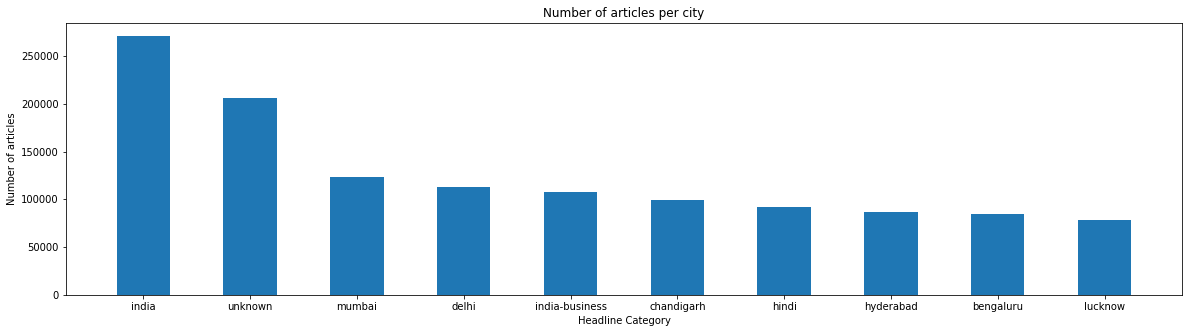

In [10]:
plot_counter(headline_df, 
             title="Number of articles per city",
             xlabel="Headline Category",
             ylabel="Number of articles")

In [11]:
df.head(5)

,headline_category,headline_text,created_at
0,sports.wwe,win over cena satisfying but defeating underta...,20010101
1,bollywood,Raju Chacha,20010102
2,unknown,Status quo will not be disturbed at Ayodhya; s...,20010102
3,unknown,Fissures in Hurriyat over Pak visit,20010102
4,unknown,America's unwanted heading for India?,20010102


In [12]:
def convert_to_datetime(df):
    """
    Input - A DF to convert df.publish_dates to to_datetime
    Returns - A converted DF
    """
    dates = df.created_at
    dates = dates.apply(lambda x: str(x))
    dates = pd.to_datetime(dates)
    df['created_at'] = dates
    return df


def filter_headlines(df, keywords):
    """
    Input - A DF for filtering headlines based on
            keywords
    Returns - Filtered DFA
    """
    assert(keywords != None)
    assert(len(keywords) != 0)

    if isinstance(keywords, str):
        keywords = [keywords]

    resultant_df = pd.DataFrame(df.head(1).copy(deep=True), df.columns)

    # Iteratively apply the filter for each word
    for keyword in keywords:
        temp_df = df[df['headline_text'].str.contains(keyword, na=False)]
        print(keyword, "found in", temp_df.shape[0], "rows")
        resultant_df = resultant_df.append(temp_df.copy(deep=True))

    curr_len = len(resultant_df)
    resultant_df.drop_duplicates(inplace=True)

    print("Dropped", curr_len - len(resultant_df), "duplicate rows")

    return resultant_df

In [13]:
df = convert_to_datetime(df)

filtered_df = filter_headlines(
    df, ['bjp', 'govt', 'government', 'elect',
         'riot', 'protest', 'unrest', 'politic',
         'violen', 'scam', 'gang', 'modi', 'attac'])
print("Current shape:", filtered_df.shape)

bjp found in 150 rows
govt found in 35274 rows
government found in 11661 rows
elect found in 22416 rows
riot found in 5056 rows
protest found in 18492 rows
unrest found in 532 rows
politic found in 10998 rows
violen found in 5588 rows
scam found in 11700 rows
gang found in 9349 rows
modi found in 890 rows
attac found in 22155 rows
Dropped 4634 duplicate rows
Current shape: (149630, 3)


In [14]:
# Get news from 2016 and with city tag
filtered_df = filtered_df[filtered_df.headline_category.str.contains('city', na=False)]

filtered_df = filtered_df[filtered_df.created_at.dt.year > 2015]
print("Current shape:", filtered_df.shape)

Current shape: (33832, 3)


In [15]:
filtered_df.head(5)

,headline_category,headline_text,created_at
2457153,city.ahmedabad,bjp planning to advance gujarat assembly elect...,2016-12-19
2471496,city.mumbai,bjp silence on bmc pact worries senabjp silent...,2017-01-09
2475103,city.pune,bjp amp shiv sena hopeful of alliance for pimp...,2017-01-14
2476394,city.mumbai,hazare bjp mla get legal lessons over pilsanna...,2017-01-16
2477628,city.dehradun,protesting workers march to party office bjp r...,2017-01-18


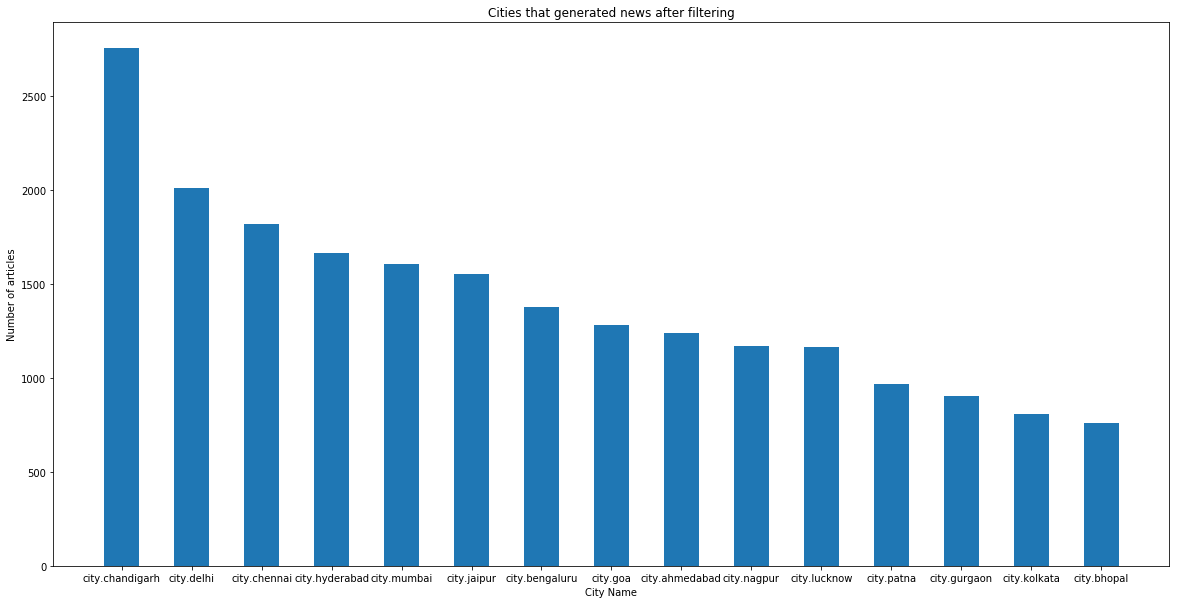

In [16]:
filtered_df.sort_values(by="created_at", inplace=True)

plot_counter(filtered_df.headline_category, num_elements=15, 
             title="Cities that generated news after filtering",
             xlabel="City Name", ylabel="Number of articles")

In [17]:
cities = pd.unique(filtered_df.headline_category)
for city in cities:
    if "." in city:
        city_df = filtered_df[filtered_df.headline_category == city]
        print(city)
        print("Min date:", city_df.iloc[0]["created_at"].date())
        print("Max date:", city_df.iloc[-1]["created_at"].date())
        print()

city.chandigarh
Min date: 2016-01-01
Max date: 2018-12-31

city.jaipur
Min date: 2016-01-01
Max date: 2018-12-31

city.nagpur
Min date: 2016-01-01
Max date: 2018-12-26

city.trichy
Min date: 2016-01-01
Max date: 2018-12-28

city.vadodara
Min date: 2016-01-01
Max date: 2018-12-31

city.thiruvananthapuram
Min date: 2016-01-01
Max date: 2018-12-31

city.delhi
Min date: 2016-01-01
Max date: 2018-12-31

city.imphal
Min date: 2016-01-01
Max date: 2018-12-23

city.mumbai
Min date: 2016-01-01
Max date: 2018-12-29

city.chennai
Min date: 2016-01-01
Max date: 2018-12-31

city.indore
Min date: 2016-01-01
Max date: 2018-12-27

city.patna
Min date: 2016-01-01
Max date: 2018-12-31

city.hyderabad
Min date: 2016-01-01
Max date: 2018-12-30

city.gurgaon
Min date: 2016-01-01
Max date: 2018-12-29

city.goa
Min date: 2016-01-01
Max date: 2018-12-31

city.lucknow
Min date: 2016-01-01
Max date: 2018-12-31

city.pune
Min date: 2016-01-02
Max date: 2018-12-31

city.jamshedpur
Min date: 2016-01-02
Max date: 2

In [50]:
# Dictify cities
cities = {x: (x.split(".")[1]).title() for x in cities if "." in x}

# Delhi fix
cities["city.delhi"] = "Delhi-New Delhi"

In [51]:
cities_set = set(cities.values())
acled_set = set(labels.keys())
common_locations = cities_set & acled_set

In [53]:
warnings.filterwarnings("ignore")
start_date, end_date = filtered_df.iloc[0]['created_at'], filtered_df.iloc[-1]['created_at']

try:
    temp = filtered_df.headline_category
    filtered_df["finallocation"] = temp
    del filtered_df["headline_category"]
except:
    pass

filtered_df = get_headlines_sentiment(filtered_df)

location_date_dict = interleave_location_and_date(filtered_df, start_date, end_date)
warnings.filterwarnings("default")

In [54]:
location_feature_dict = {}
for location in location_date_dict:
    city = cities.get(location)
    if city is not None and city in common_locations:
        location_feature_dict[city] = get_features(location_date_dict[location])

city.chandigarh
city.jaipur
city.nagpur
city.trichy
city.vadodara
city.thiruvananthapuram
city.delhi
city.imphal
city.mumbai
city.chennai
city.indore
city.patna
city.hyderabad
city.gurgaon
city.goa
city.lucknow
city.pune
city.jamshedpur
city.ahmedabad
city.kozhikode
city.bhubaneswar
city.visakhapatnam
city.navi-mumbai
city.kanpur
city.cuttack
city.kolkata
city.ludhiana
city.madurai
city.aurangabad
city.jammu
city.bhopal
city.noida
city.ranchi
city.bengaluru
city.srinagar
city.surat
city.agartala
city.guwahati
city.kochi
city.shimla
city.jind
city.coimbatore
city.thane
city.raipur
city.kolhapur
city.salem
city.dehradun
city.vijayawada
city.shillong
city.hubballi
city.amritsar
city.meerut
city.varanasi
city.mysuru
city.erode
city.allahabad
city.faridabad
city.mangaluru
city.nashik
city.puducherry
city.rajkot
city.rajahmundry
city.agra
city.bareilly
city.ghaziabad
city.itanagar
city.kohima
city.ajmer
city.jodhpur
city.udaipur
city.gaya
city.amaravati
city
city.navi-mumbai.govt-to-transfer

In [55]:
location_feature_dict.keys()

dict_keys(['Chandigarh', 'Jaipur', 'Thiruvananthapuram', 'Delhi-New Delhi', 'Imphal', 'Chennai', 'Patna', 'Hyderabad', 'Gurgaon', 'Lucknow', 'Ahmedabad', 'Bhubaneswar', 'Kolkata', 'Ludhiana', 'Jammu', 'Ranchi', 'Bengaluru', 'Srinagar', 'Guwahati', 'Shimla', 'Coimbatore', 'Dehradun', 'Amritsar', 'Puducherry'])

In [38]:
model = ExtraTreesClassifier(n_estimators=400, n_jobs=-1)
def make_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
    Returns - None
    """
    # Table for presenting on tabulate
    result_table = []

    # Suppress warnings for divide-by-zero error
    warnings.filterwarnings("ignore")

    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())

    # Sorted for clarity
    common_locations = sorted(list(common_locations))

    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)
        y = U.to_categorical(y)
        
        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]

        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]

        # Default model
        if model is None:
            model = create_model(6)

        # Fit the train data
        model.fit(xtrain, ytrain, epochs=20, validation_data=(xtest, ytest), verbose=0)

        # Make predictions
        ypred_train = model.predict(xtrain)
        ypred = model.predict(xtest)
        
        uncategorize = lambda x: np.argmax(x, axis=1)

        # Compute metrics
        ytest, ypred = uncategorize(ytest), uncategorize(ypred)
        test_accuracy = accuracy_score(ytest, ypred)
        precision = precision_score(ytest, ypred)
        recall = recall_score(ytest, ypred)
        f1 = f1_score(ytest, ypred)
        # Add row to result_table
        result_row = [common_location, np.round(test_accuracy, 2),
                      np.round(precision, 2), np.round(recall, 2),
                      np.round(f1, 2)
                     ]
        result_table.append(result_row)

    # Average stats
    # Turns out median is kind of useless
    result_table_copy = (np.array(result_table)[:, 1:]).astype(np.float32)
    averages = np.round(np.mean(result_table_copy, axis=0), 2)

    # Add them to the existing result table
    result_table.append(["Average"] + averages.tolist())

    # Print tabulated result
    header = ["Location", "Test Accuracy", "Precision", "Recall", "F1 Score"]

    print(
        tabulate(result_table,
                 header,
                 tablefmt="github",
                 stralign="center")
    )

    # Unsuppress warning
    warnings.filterwarnings("default")

def create_model(num_features):
    """
    num_features - Number of features for input_shape
    """
    model = M.Sequential()
    model.add(M.InputLayer(input_shape=(num_features, )))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(50, activation='relu'))
    model.add(L.Dense(2, activation='relu'))
    model.add(L.Softmax())
    
    model.compile(opt.Adam(0.01), loss="categorical_crossentropy")
    return model
make_predictions(location_feature_dict, labels, permute=False)

KeyboardInterrupt: 

In [56]:
def plot_result_df(result_df, location):
    
    # Plot location
    plt.title(location)
    
    # X-axis 
    plt.xlabel("Batch #")
    
    # Y-axis
    plt.ylabel("Metric value")
    
    # Set color for lines
    plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])
    
    # Get x-axis
    test_range = np.arange(result_df.shape[0])
    
    # Iter through each result & plot
    for header in result_df.columns:
        plt.plot(test_range, result_df[header])
        
    # Add a legend for ease of use
    plt.legend(result_df.columns, loc="upper left")
    
    # Actually plot
    plt.show()

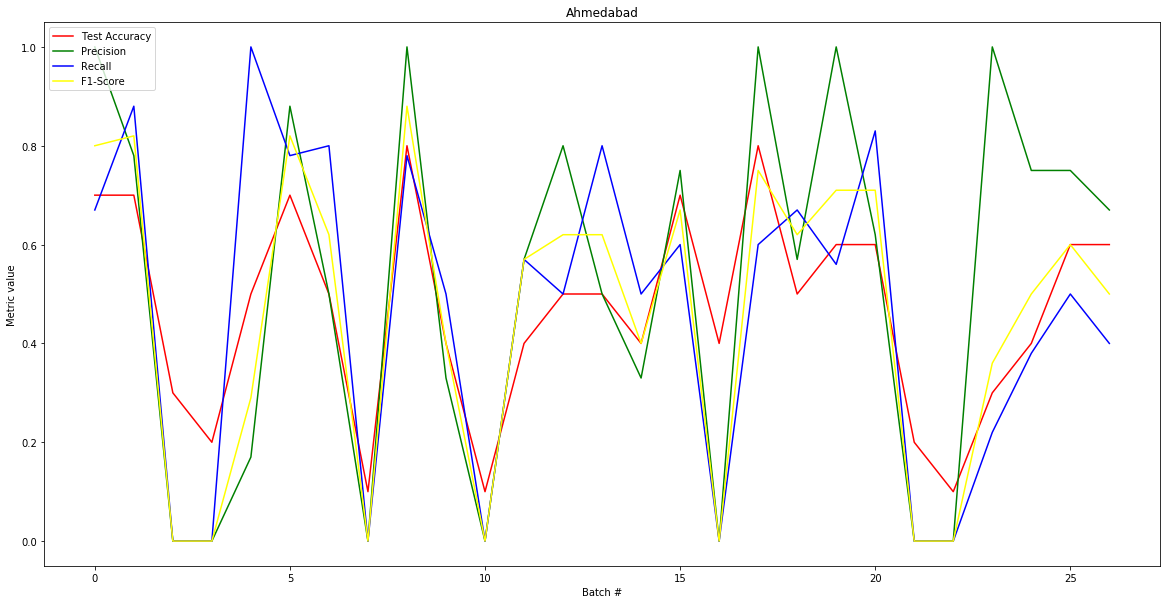

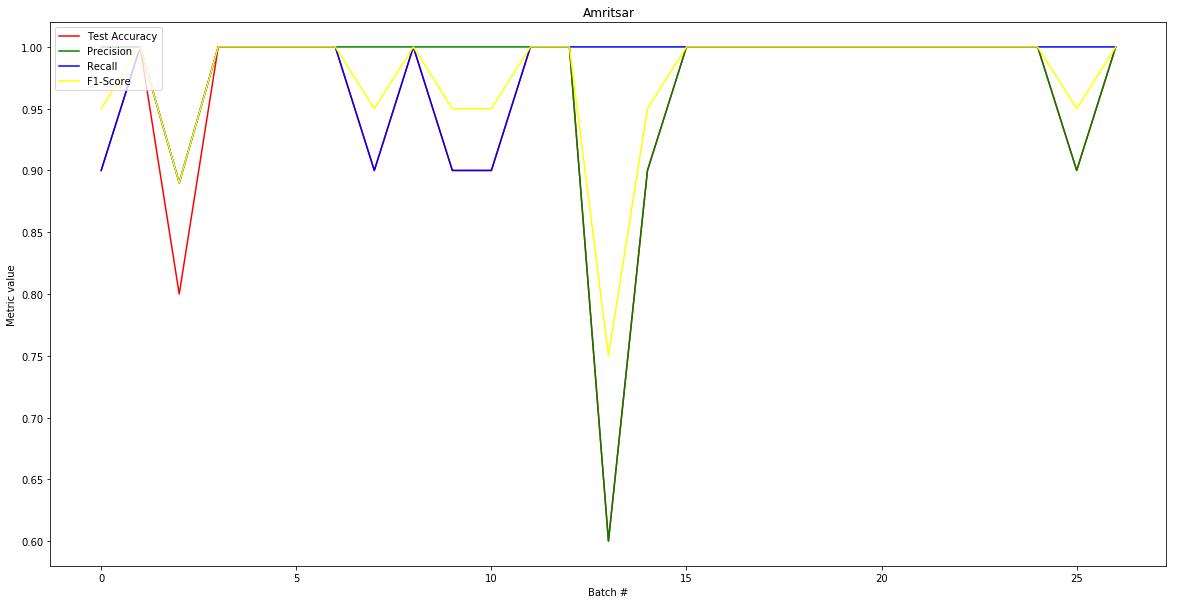

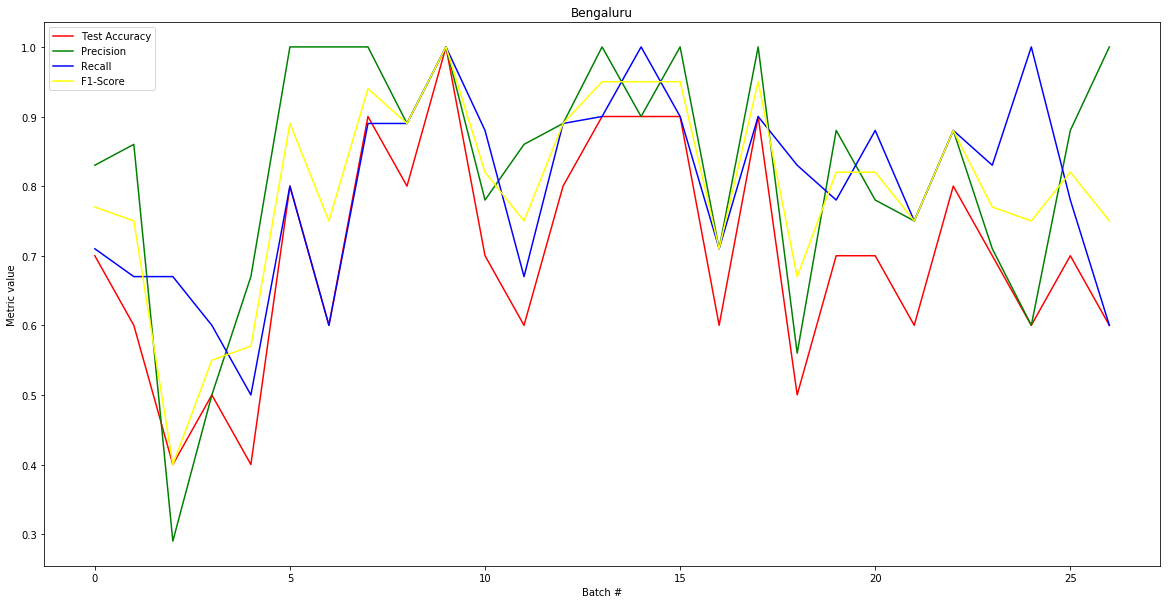

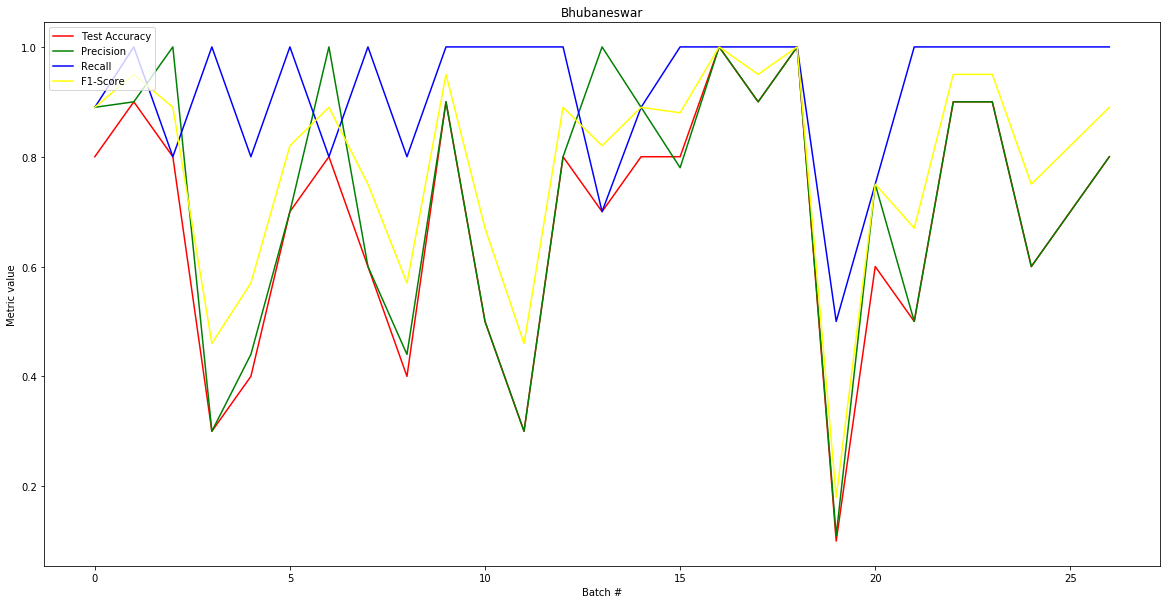

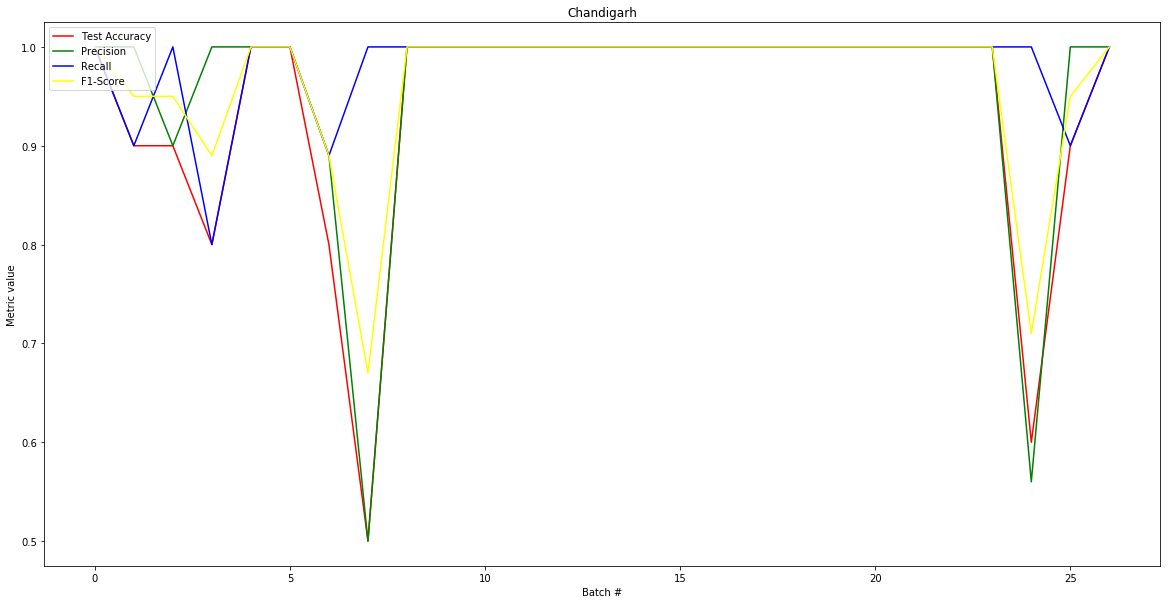

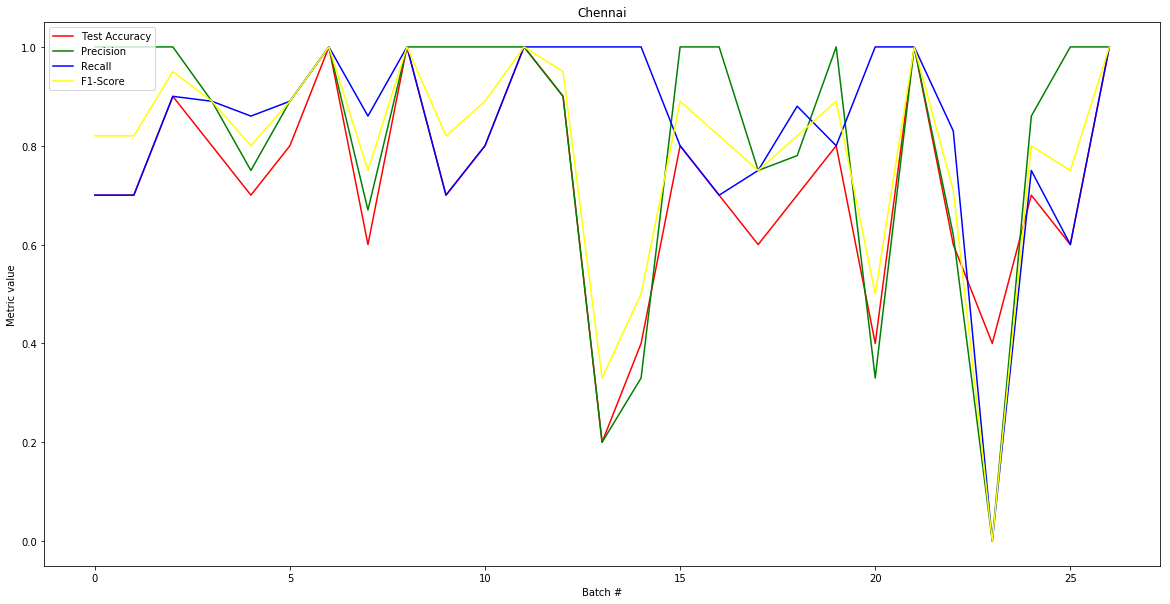

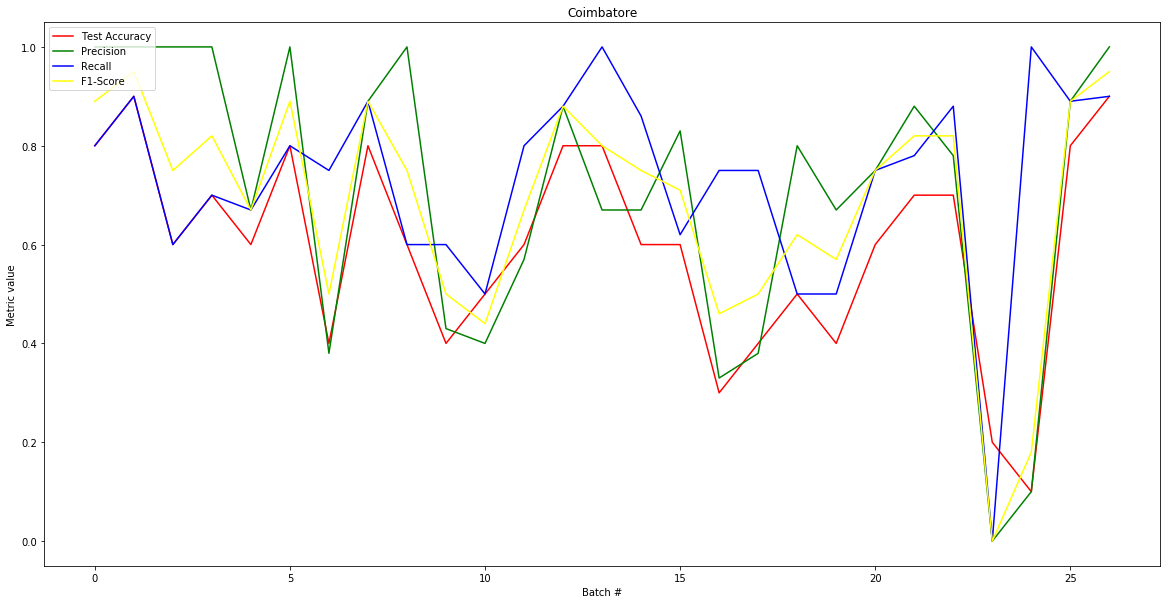

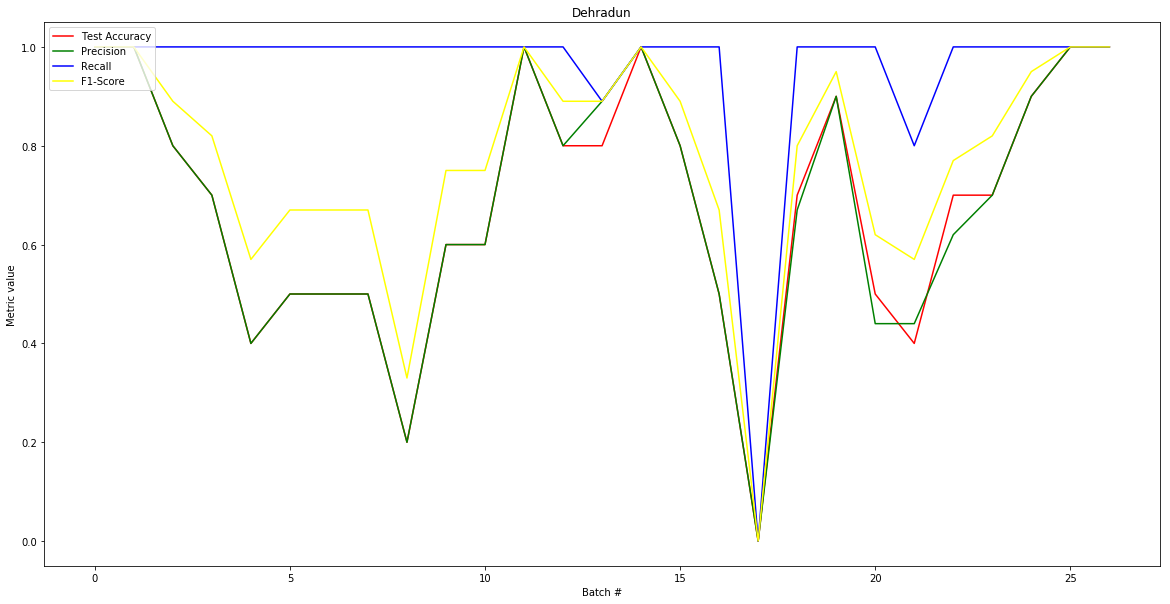

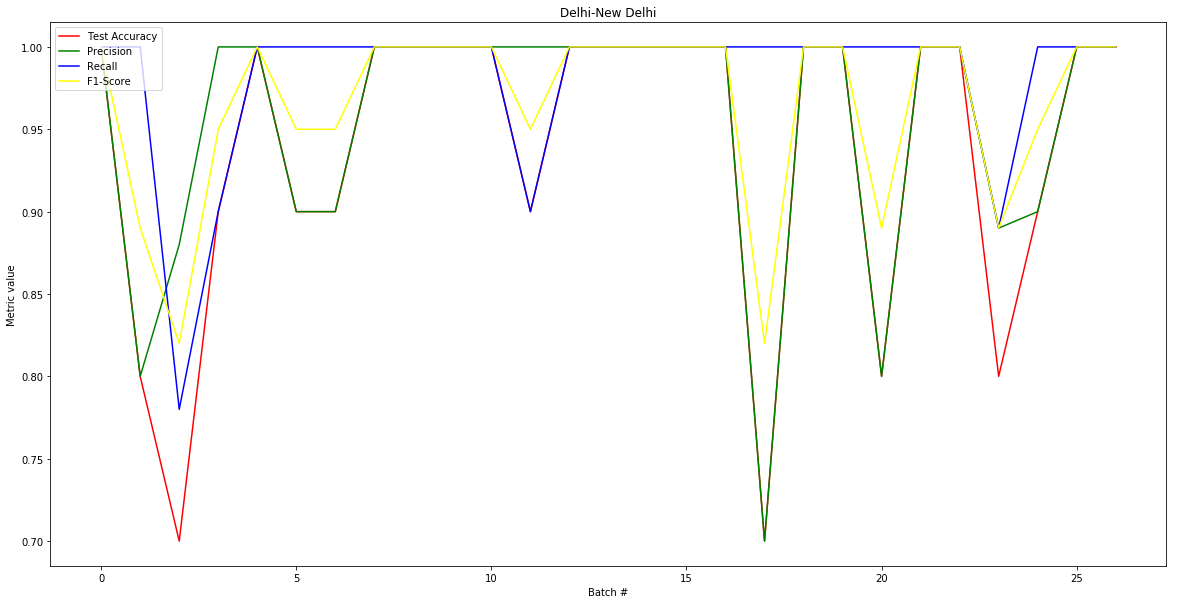

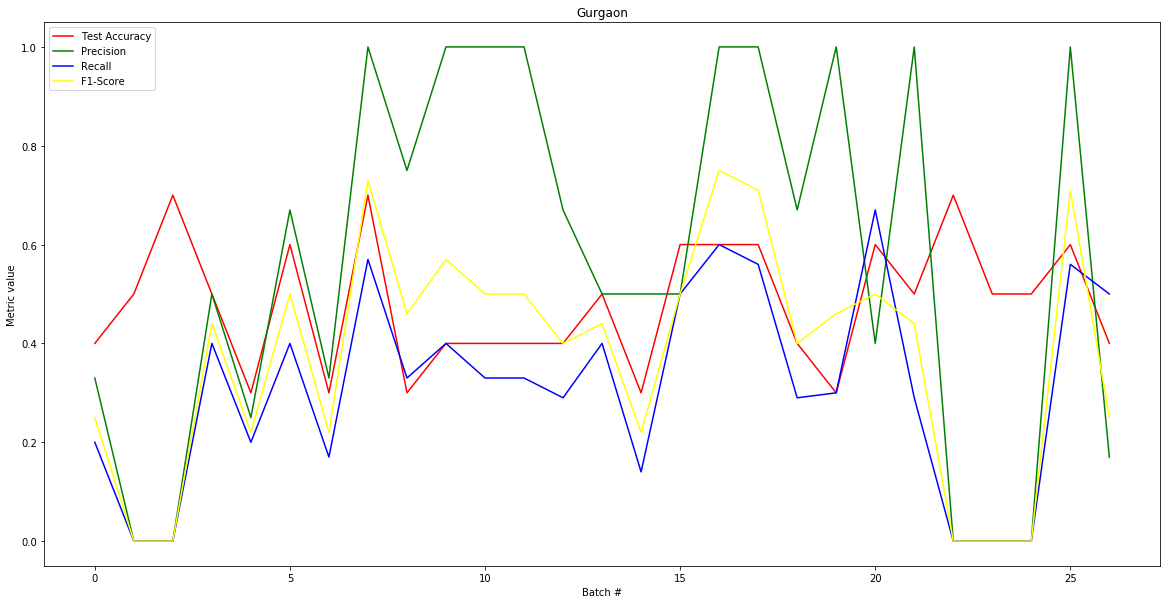

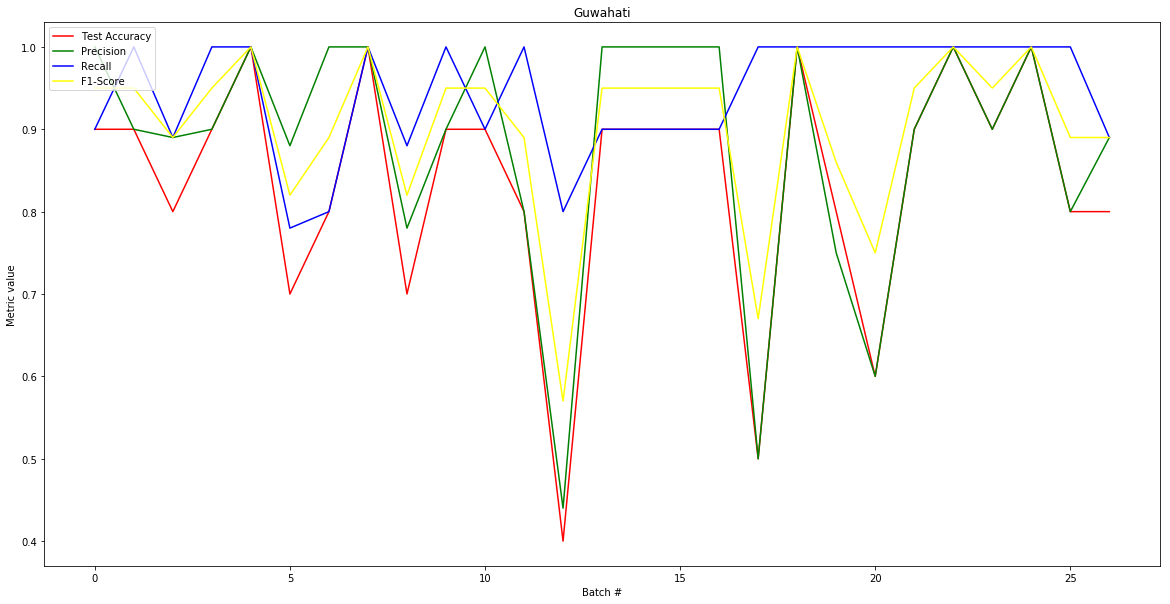

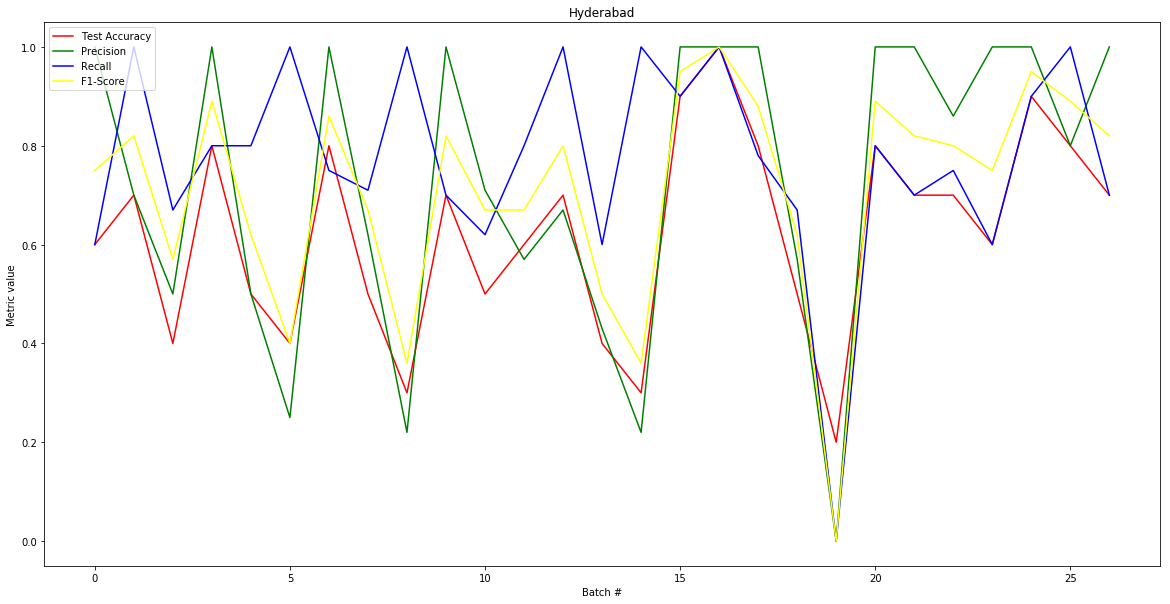

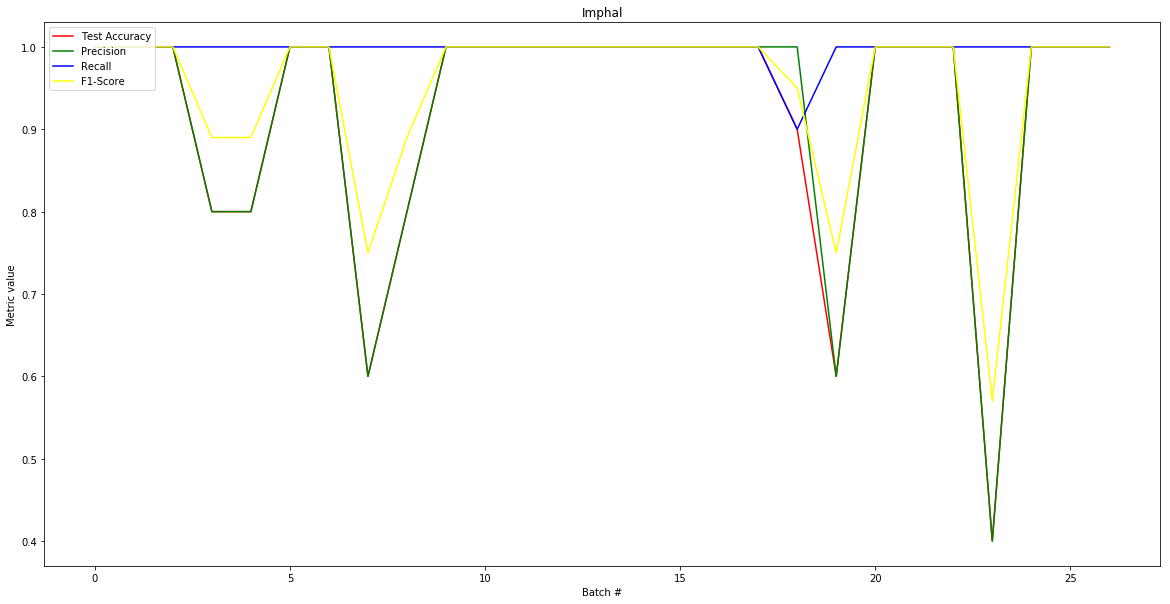

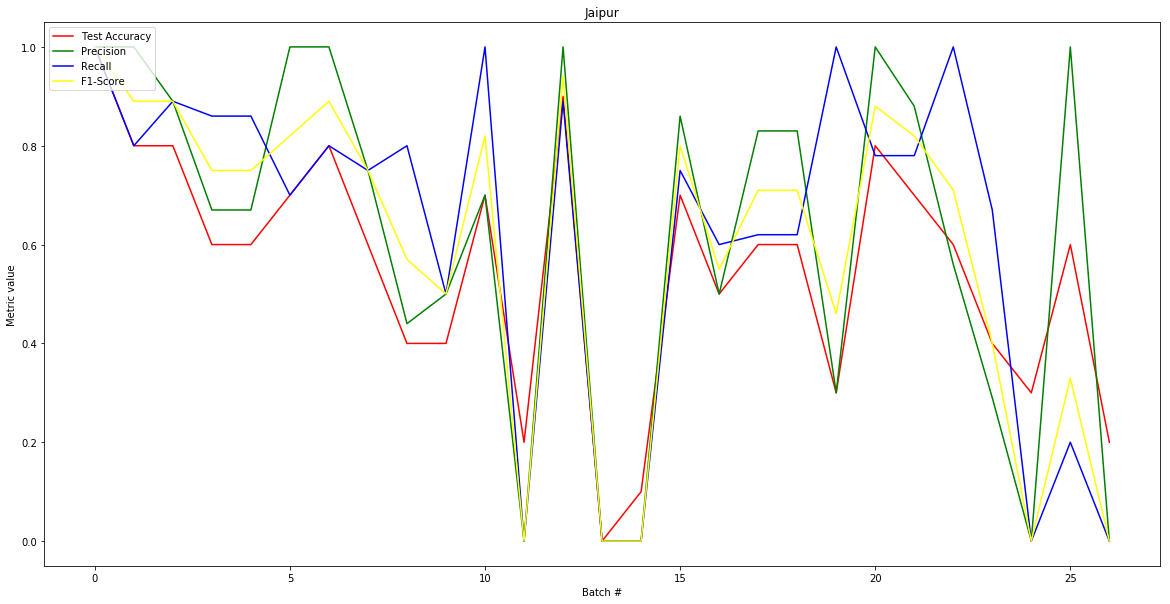

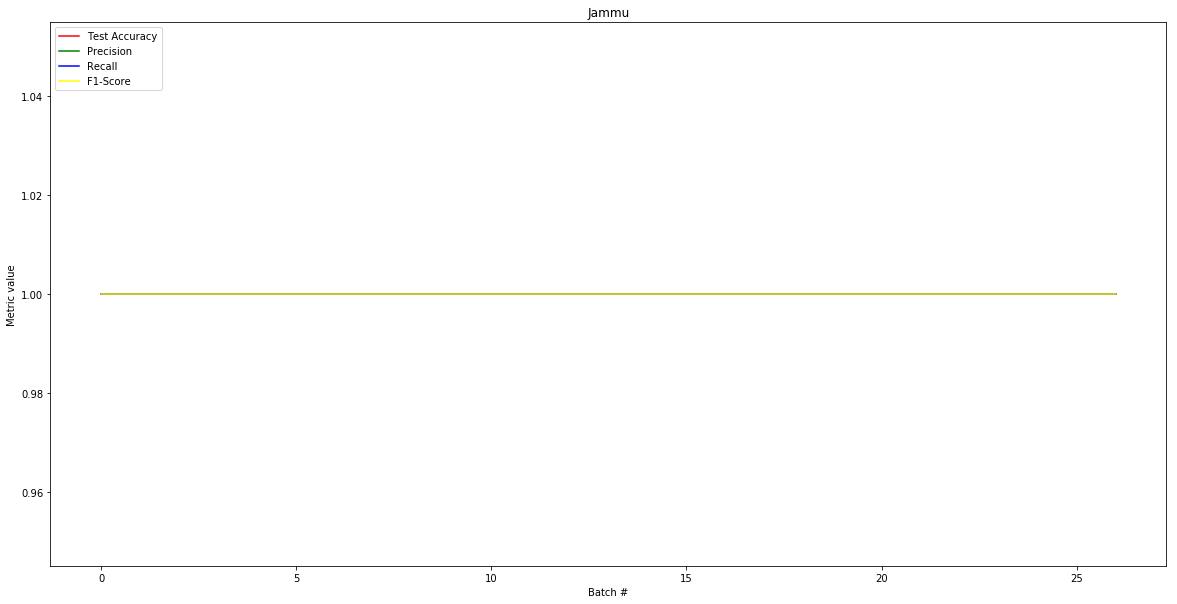

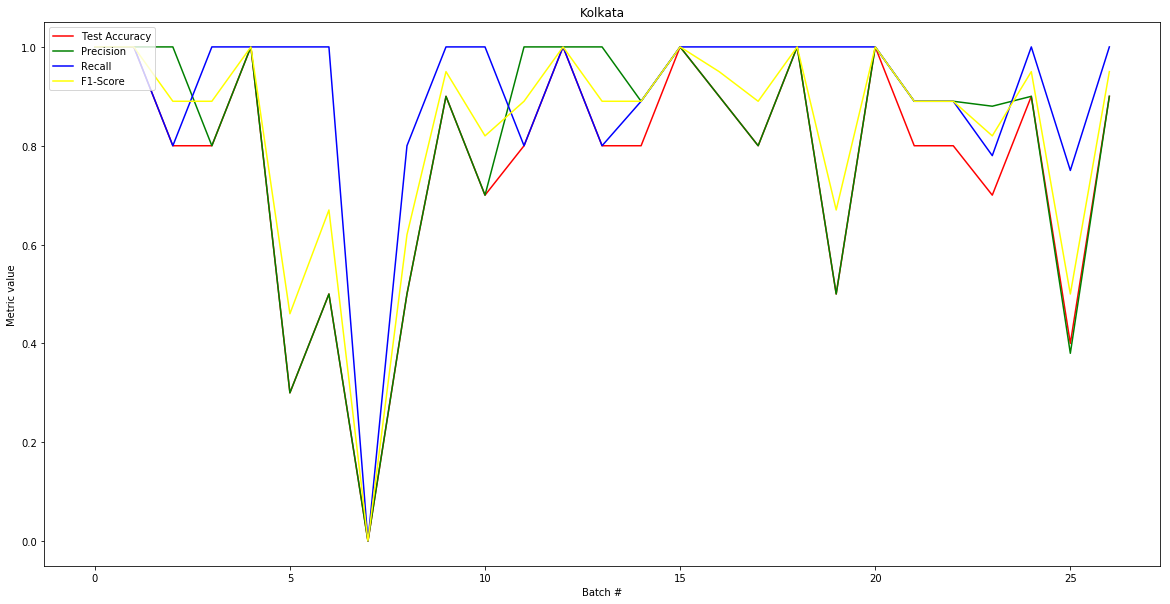

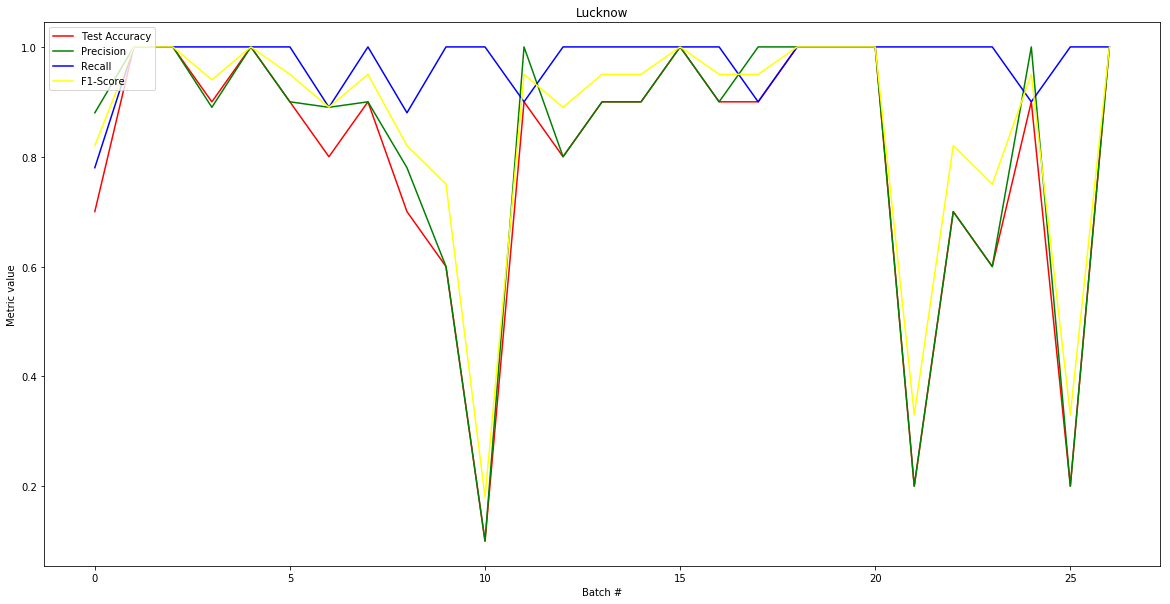

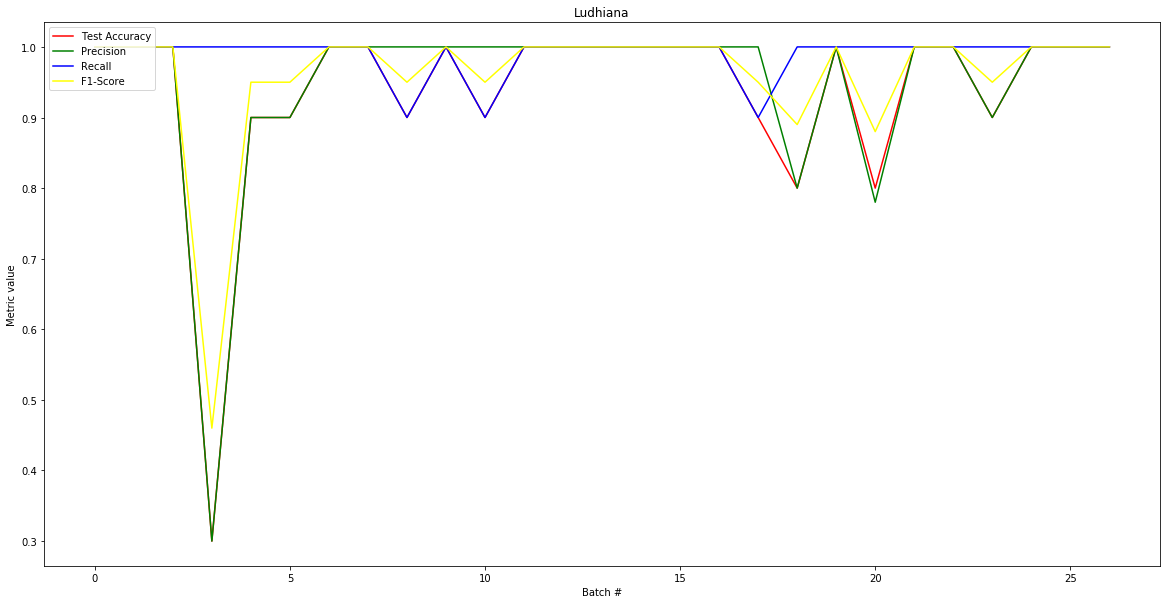

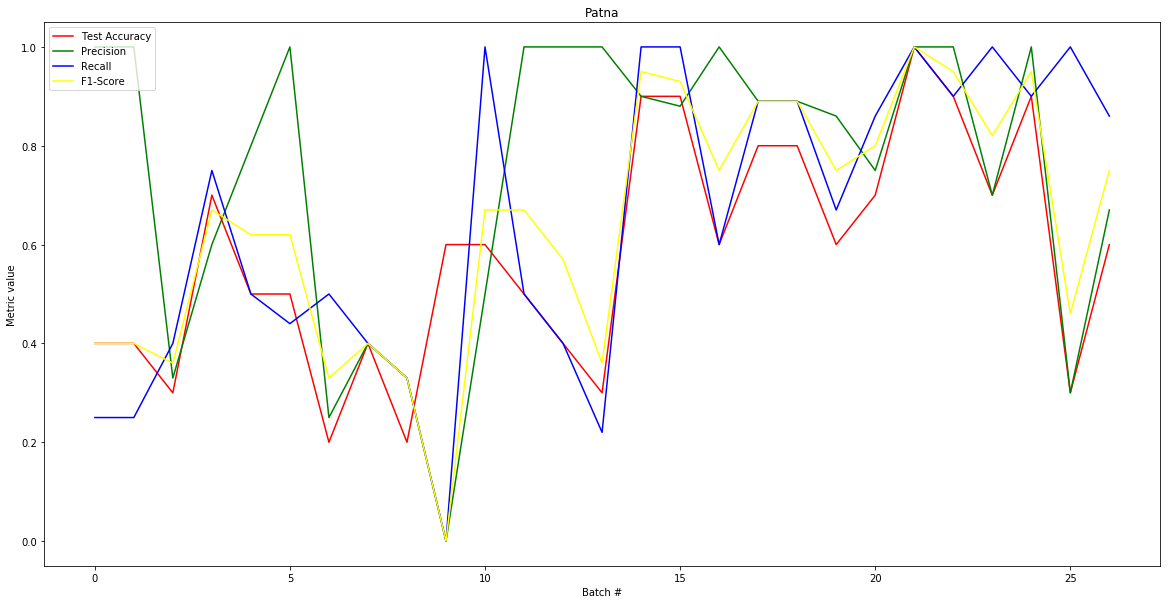

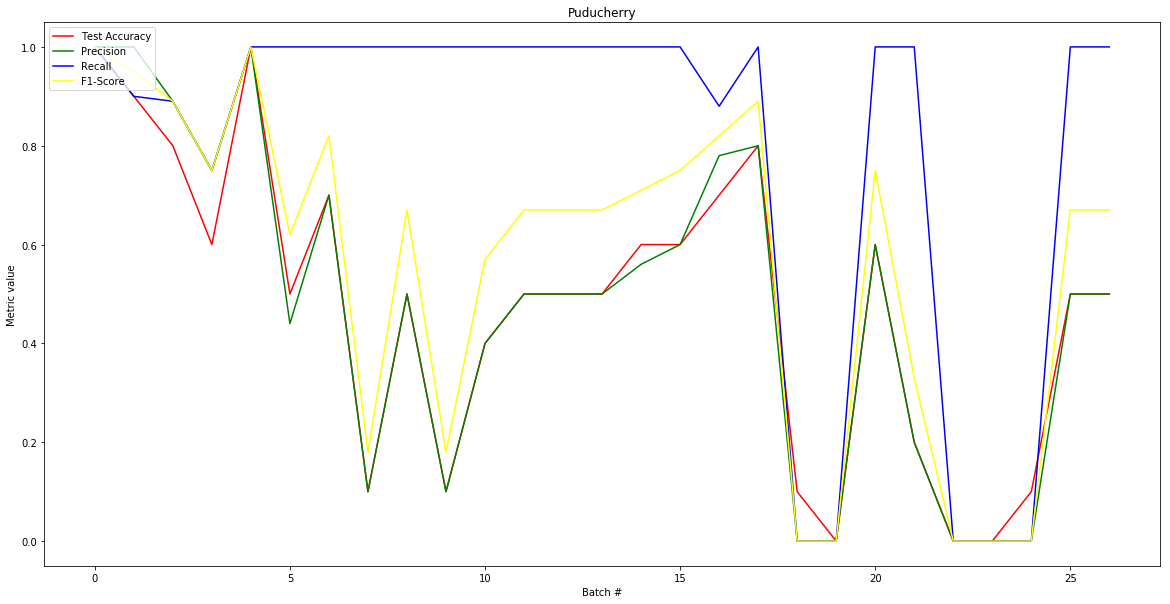

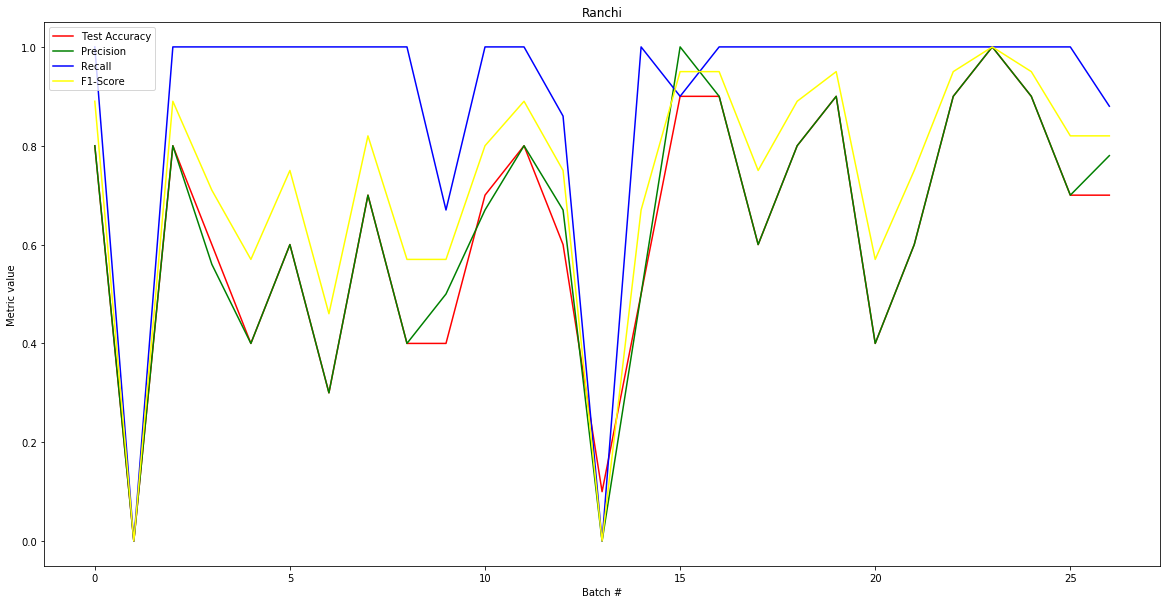

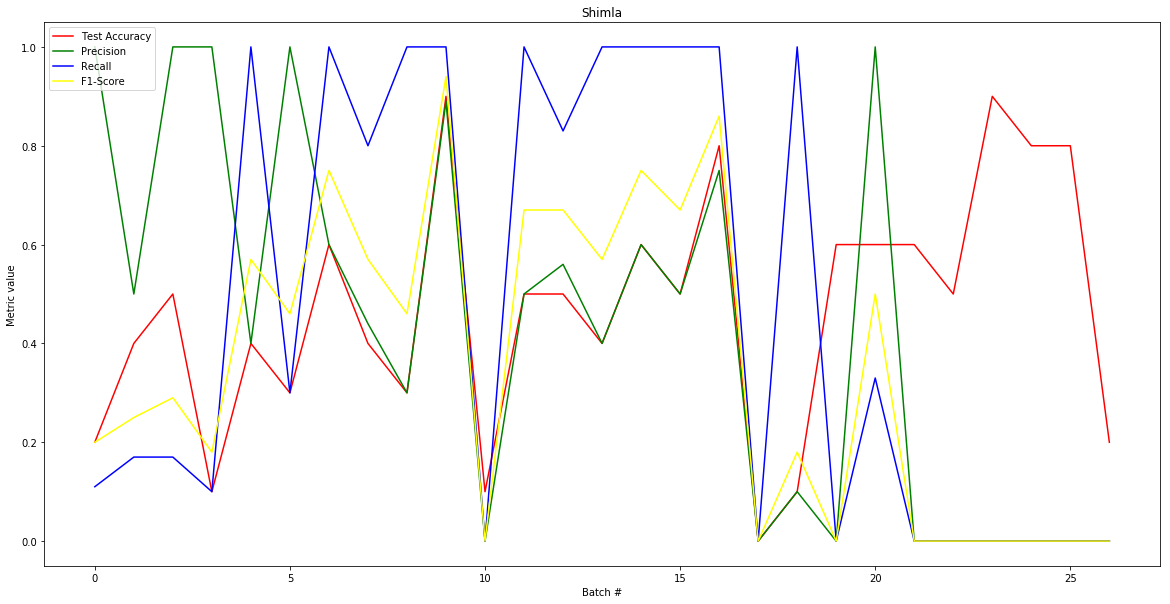

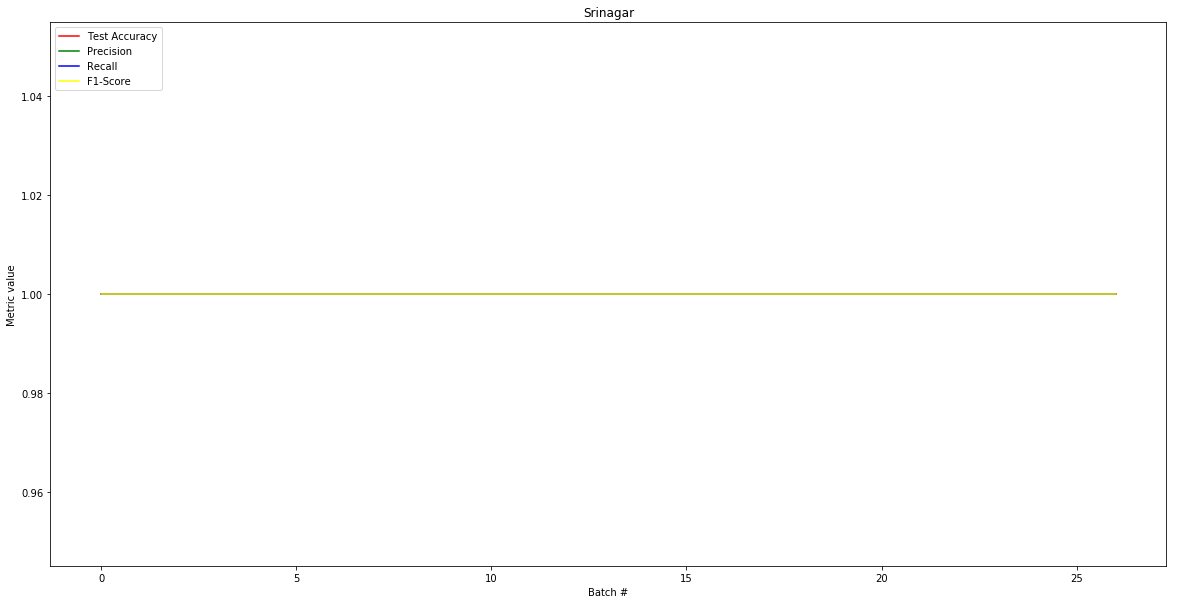

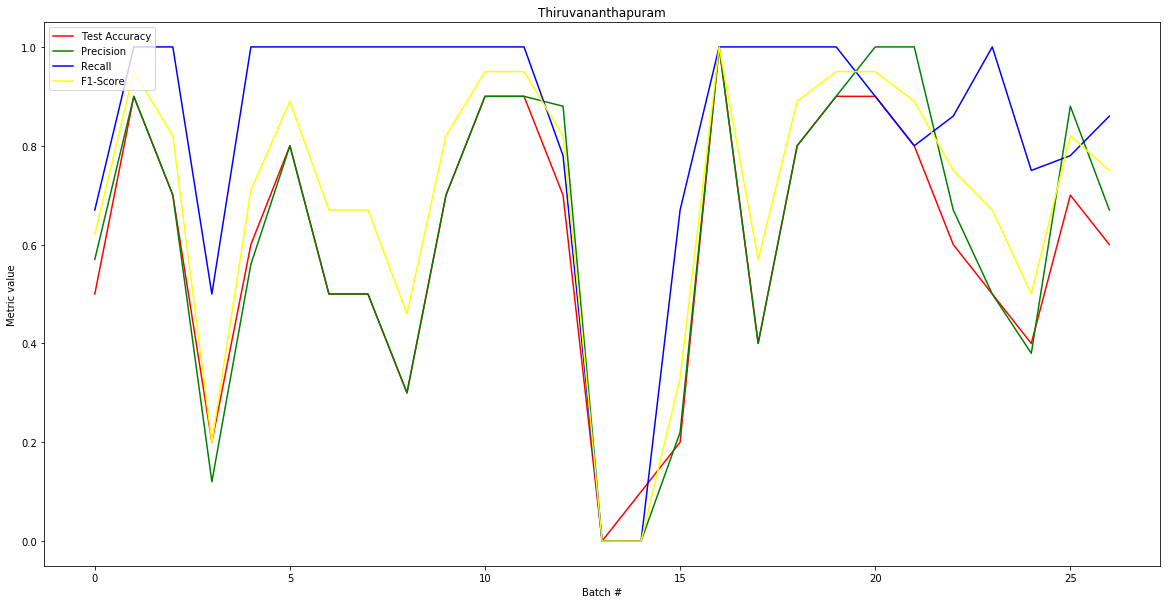

In [58]:
def make_continual_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5, batch_size=20):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
    Returns - None
    """    
    # Suppress warnings for divide-by-zero error
    warnings.filterwarnings("ignore")
    
    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())
    
    # Sorted for clarity
    common_locations = sorted(list(common_locations))
    
    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)
        
        # Table for presenting on tabulate
        result_table = []

        
        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]

        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]
        
        # Default model
        if model is None:
            model = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)

        # Fit the train data
        model.fit(xtrain, ytrain)
        
        # Get number of test days
        num_test_days = xtest.shape[0]
        
        
        # Test range
        test_range = np.arange(0, num_test_days - batch_size, batch_size)
        
        # Iter through this range
        for i in test_range:
            
            ypred = model.predict(xtest)
            # Get batch and predict for this batch
            ypred_batch = ypred[i: i + batch_size]
            ytest_batch = ytest[i: i + batch_size]
            
            # Compute metrics
            test_acc = np.mean(ypred_batch == ytest_batch)
            precision = precision_score(ytest_batch, ypred_batch)
            recall = recall_score(ytest_batch, ypred_batch)
            f1 = f1_score(ytest_batch, ypred_batch)

            # Add row to result_table
            result_row = [np.round(test_acc, 2),
                          np.round(precision, 2), np.round(recall, 2),
                          np.round(f1, 2)
                         ]
            result_table.append(result_row)
            xtrain = np.vstack((xtrain, xtest[i: i + batch_size]))
            ytrain = np.concatenate((ytrain, ytest_batch))
            model.fit(xtrain, ytrain)
            
        columns = ["Test Accuracy", 
                  "Precision", "Recall",
                  "F1-Score"]
            
        result_df = pd.DataFrame(result_table, columns=columns)
        plot_result_df(result_df, common_location)
        
    warnings.filterwarnings("default")
    return


make_continual_predictions(location_feature_dict, labels, permute=False, batch_size=10)